In [26]:
from salishsea_tools import viz_tools
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cm
import matplotlib as mpl
import cv2

In [20]:
import salishsea_tools.river_202108 as rivers

In [15]:
physics_202111 = xr.open_dataset('/ocean/cdonaldson/compare_daily_river/SalishSeaCast_day_avg_physics_20190101_20191231.nc')
year = 2019

In [16]:
phys_arr = physics_202111.vosaline.to_numpy()

# open the mesh mask and use it to mask the land
mesh = xr.open_dataset('../../../../MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]
tmask = tmask[0:20, :, :]

In [21]:
box_size = 30
Nooksack = river_box('fraser', 'Nooksack', box_size)

In [23]:
tmask.shape

(20, 898, 398)

## Birgit's method

In [76]:
tstep = 0

# mask array of grid box thickness based on where there is land (tmask):
# e3t_mask = np.ma.masked_where((tmask[:,:,:] < 0.1), phys_1d[:,:,:])
e3t_mask = np.ma.masked_array(physics_202111.vosaline[tstep, :], mask=tmask[:])

# find index of grid cell just above the ocean floor by finding the edges for the array along the z-axis:
ind = np.array(np.ma.notmasked_edges(e3t_mask[:,:,:], axis=1)) # e3t shape: (z,x,y)

# create array of shape (isize, jsize) containing bottom grid cell indices:
isize = 898
jsize = 398
# index_sides = ind[1][0][:].reshape(isize,jsize)

ValueError: cannot reshape array of size 7787 into shape (898,398)

In [77]:
ind.shape

(2, 3, 7787)

In [63]:
ind[1][0]

array([465, 465, 465, 465, 465, 465, 464, 464, 463, 462, 461, 460, 459,
       454, 449, 444, 441, 437, 434, 434, 430, 427, 427, 426, 426, 424,
       423, 422, 420, 419, 419, 418, 417, 416, 415, 414, 413, 412, 411,
       411, 410, 409, 408, 407, 896, 896, 896, 896, 896, 896, 896, 896,
       896, 896, 896, 891, 891, 890, 889, 889, 888, 888, 888, 888, 888,
       888, 888, 888, 883, 883, 882, 882, 881, 881, 881, 880, 880, 880,
       880, 880, 880, 880, 880, 880, 880, 880, 879, 880, 880, 880, 880,
       880, 880, 881, 881, 875, 875, 875, 874, 874, 873, 859, 855, 855,
       855, 855, 854, 854, 853, 853, 853, 853, 853, 853, 853, 853, 853,
       854, 854, 854, 855, 856, 857, 857, 858, 859, 859, 860, 861, 861,
       865, 866, 866, 866, 866, 867, 868, 868, 869, 869, 869, 872, 877,
       877, 878, 878, 880, 882, 883, 885, 886, 887, 888, 888, 888, 889,
       890, 892, 892, 892, 892, 893, 892, 892, 892, 891, 891, 891, 891,
       891, 892, 892, 896, 896, 896, 895, 895, 895, 895, 839, 81

In [66]:
ind[1][1]

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [55]:
len(ind[0][0])

394

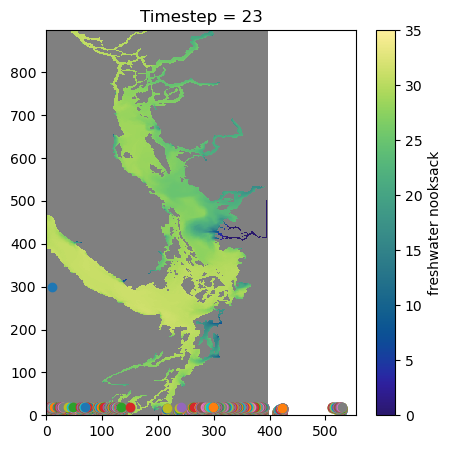

In [81]:
tstep = 23

cmap = cm.haline
cmap.set_bad('gray')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
freshwater = np.ma.masked_array(physics_202111.vosaline[tstep, 0], mask=tmask[0])
colours = ax.pcolormesh(freshwater, cmap=cmap, vmin=0, vmax=35)
cb = fig.colorbar(colours, ax=ax)
cb.set_label('freshwater nooksack')
ax.set_title('Timestep = {}'.format(str(tstep)))
ax.scatter(10, 300)
# ax.set_ylim(Nooksack[0], Nooksack[1])
# ax.set_xlim(Nooksack[2], Nooksack[3])

for i in np.arange(len(ind[0][0])):
    ax.scatter(ind[0][1][i], ind[0][0][i])

## It looks like I can maybe downscale the array first?

Tereza's paper describes a method in which stations are selected throughout the SOG, which seems like a pixel-selection method of decreasing resolution. I think I want to do averages to downscale? But I should be careful since I ultimately only want the near-coastline points in the end.

In [ ]:
# ## from ChatGPT, turn this into my own function?

# # Create a sample array (replace this with your own data)
# original_array = phys_arr[0,0,:,:]

# # Define the scale factor (e.g., 2 for halving the dimensions)
# scale_factor = 10

# # Calculate the new dimensions for the downsampled array
# new_height = original_array.shape[0] // scale_factor
# new_width = original_array.shape[1] // scale_factor

# # Create an empty array for the downsampled result
# downsampled_array = np.zeros((new_height, new_width), dtype=original_array.dtype)

# # Downscale the array by taking the average of each group of pixels
# for y in range(new_height):
#     for x in range(new_width):
#         y_start = y * scale_factor
#         y_end = y_start + scale_factor
#         x_start = x * scale_factor
#         x_end = x_start + scale_factor
#         downsampled_array[y, x] = np.mean(original_array[y_start:y_end, x_start:x_end])

In [ ]:
# # Load your matrix as an image (assuming you have NaN values for land)
# data_matrix = phys_arr

# # Create a binary mask where land (NaN values) are set to 0 and water is set to 255
# binary_mask = np.where(np.isnan(data_matrix), 0, 255).astype(np.uint8)

# # Find contours in the binary mask
# contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # Assuming you want to extract the outermost contour as the coastline
# coastline_contour = max(contours, key=cv2.contourArea)

# # Extract coordinates from the coastline contour
# coastline_coordinates = coastline_contour.reshape(-1, 2)

# # Now, coastline_coordinates contains the coordinates of the coastline.